## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [3]:
# Чтение и оценка вида данных
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Исследование структуры данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


Столбец date имеет тип object, для доступа к функциям работы с датой приведём его к типу Pandas datetime.

## Период проведения AB теста

In [5]:
# Преобразуем тип данных
data['date'] =pd.to_datetime(data['date'])

# Длительность теста группы А и группы B
period_a = (data[data['group'] == 'A']['date'].min(), data[data['group'] == 'A']['date'].max())
period_b = (data[data['group'] == 'B']['date'].min(), data[data['group'] == 'B']['date'].max())

print(f'Период проведения теста для группы А: {period_a}')
print(f'Период проведения теста для группы B: {period_b}')

Период проведения теста для группы А: (Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-24 00:00:00'))
Период проведения теста для группы B: (Timestamp('2021-01-02 00:00:00'), Timestamp('2021-01-24 00:00:00'))


## Размеры выборки

In [6]:
# количество посещений сайта
data['group'].value_counts()

B    147276
A    147202
Name: group, dtype: int64

Количество посещений сайта в группе А составило 147 202 (49.99%), в группе В - 147 276 (50.01%) 

In [7]:
# суммарное количество покупок
data.groupby('group', as_index=False).agg(purchase_qty=('purchase', 'sum'))

,group,purchase_qty
0,A,17723
1,B,17514


Количество покупок в группе А составило 17 723, в группе В - 17 514

In [8]:
# сумма покупок в группах А и В
data_sum = data.groupby('group', as_index=False).agg(purchase_sum=('price', 'sum'))
data_sum['purchase_sum'] = data_sum['purchase_sum']/1000000

data_sum

,group,purchase_sum
0,A,1436.26
1,B,1554.10


Общая сумма покупок в группе А составила 1 436.26 млн.руб., в группе В - 1 554.10 млн.руб.

Проверим, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы

In [9]:
# множества id пользователей для каждой группы
set_a = set(data[data['group'] == 'A']['user_id'])
set_b = set(data[data['group'] == 'B']['user_id'])

# и их пересечение
user_intersection = set_a & set_b
print(f'Количество пользователей, попавших одновременно в обе группы: {len(user_intersection)}')

Количество пользователей, попавших одновременно в обе группы: 1895


Исключим таких пользователей

In [10]:
# воспользуемся авторским вариантом :)
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

# проверим количество строк
updated_data.shape[0]

290688

## Первичный анализ результатов AB тестирования
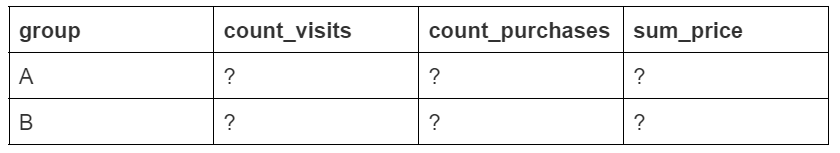

In [11]:
# ваш код здесь
data_grouped = updated_data.groupby('group', as_index=False).agg(count_visits=('group', 'count'), # количество посещений
                                                         count_purchases=('purchase', 'sum'), # количество покупок
                                                         sum_price=('price', 'sum')) # сумма покупок

data_grouped

,group,count_visits,count_purchases,sum_price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Количество пользователей практически равно в обеих группах. Выборки сбалансированы.

In [12]:
# конверсия
data_grouped['conversion'] = data_grouped['count_purchases']/data_grouped['count_visits']*100
data_grouped['conversion'] = data_grouped['conversion'].apply(lambda x: round(x, 2))

# средний чек
data_grouped['mean_check'] = data_grouped['sum_price']/data_grouped['count_purchases']*100

data_grouped

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,8.107623e+06
1,B,145381,17290,1533010000,11.89,8.866455e+06


Вариант А оказался эффективнее по конверсии на 0.14 процентных пункта, в то время как средний чек варианта В выше на 9.3% или (7 859 р).

Сравним варианты по покупательской способности

In [13]:
# отфильтруем строки с ценой, равной нулю
mask = updated_data[updated_data['price'] != 0]

# сводная таблица: строки - цена, столбцы - группы, значения - кол-во покупок
pivot = pd.pivot_table(mask, index='price', columns=['group'], values=['purchase'], aggfunc='count')
pivot

purchase      
group         A     B
price                
10000      5182  5201
60000      5271  1730
100000     1832  5227
150000     3478  3438
200000     1724  1694

Text(0.5, 1.0, 'Зависимость кол-ва продаж от группы и цены тура')

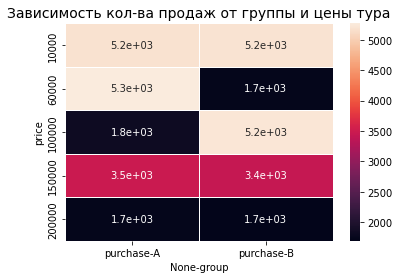

In [14]:
ax = sns.heatmap(pivot, linewidths=0.5, annot=True) # разделим значения белыми линиями и добавим аннотацию
ax.set_title('Зависимость кол-ва продаж от группы и цены тура', fontdict={'size': 14})

Напомним, какие данные по стоимости туров у нас имеются:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

Группа А: самыми популярными направлениями оказались Петербург (10 тыс руб) и Турция (60 тыс руб). Далее идёт Камчатка (150 тыс руб). На третьем месте Таиланд (100 тыс руб) и Мальдивы (200 тыс руб).

Группа В: Наиболее популярны Петербург и Таиланд (10 тыс и 100 тыс соответственно), далее Камчатка, на третьем месте Мальдивы и Турция.

**Нельзя сказать, что есть однозначная зависимость между ценой тура и кол-вом покупок. Это справедливо для обеих групп.**

*Если сравнивать группы между собой, видим, что по турам в Петербург, Мальдивы и Камчатку покупательская способность примерно одинаковая. При этом путешественники из группы А предпочли Турцию Таиланду (5.2 тыс vs 1.8 тыс). Путешественники из группы В - наоборот (1.7 тыс vs 5.2 тыс). На тепловой это отчётливо видно, цвета "меняются местами" для соответствующих значений цены.*

## Поведение кумулятивных метрик во времени

In [15]:
# группировка данных по датам и группам, вычисление дневных значений
data_daily = updated_data.groupby(['date', 'group'], as_index=False).agg(count_visits=('group', 'count'), # количество посещений
                                                                         count_purchases=('purchase', 'sum'), # количество покупок
                                                                         sum_price=('price', 'sum')) # сумма покупок)


# конверсия
data_daily['conversion'] = data_daily['count_purchases']/data_daily['count_visits']*100
data_daily['conversion'] = data_daily['conversion'].apply(lambda x: round(x, 2))

# средний чек
data_daily['mean_check'] = data_daily['sum_price']/data_daily['count_purchases']

In [16]:
# кумулятивное кол-во посещений
data_daily['cum_visits'] = data_daily.groupby(['group'])['count_visits'].cumsum()

# кумулятивное кол-во покупок
data_daily['cum_purchases'] = data_daily.groupby(['group'])['count_purchases'].cumsum()

# кумулятивная сумма покупок
data_daily['cum_price'] = data_daily.groupby(['group'])['sum_price'].cumsum()

# кумулятивная конверсия
data_daily['cum_conversion'] = data_daily['cum_purchases']/data_daily['cum_visits']*100
data_daily['cum_conversion'] = data_daily['cum_conversion'].apply(lambda x: round(x, 2))

# кумулятивный средний чек
data_daily['cum_check'] = data_daily['cum_price']/data_daily['cum_purchases']

data_daily[data_daily['date'] == '2021-01-12']

,date,group,count_visits,count_purchases,sum_price,conversion,mean_check,cum_visits,cum_purchases,cum_price,cum_conversion,cum_check
20,2021-01-12,A,6540,795,68460000,12.16,86113.207547,68852,8198,668070000,11.91,81491.827275
21,2021-01-12,B,6635,807,70560000,12.16,87434.944238,69251,8236,727670000,11.89,88352.355512


## Визуализация данных по кумулятивным метрикам

Text(0.5, 1.0, 'Кумулятивная конверсия')

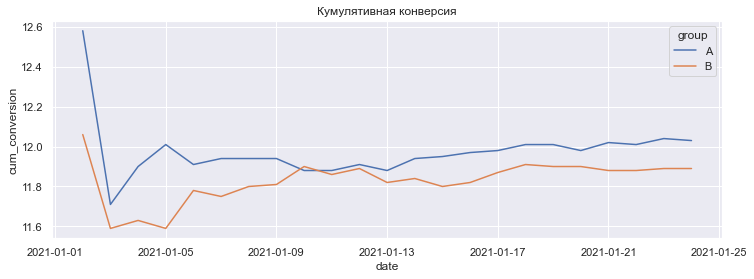

In [18]:
sns.set_theme()

# кумулятивная конверсия
fig, axes = plt.subplots(figsize=(12, 4))

#графики для каждой группы
sns.lineplot(data=data_daily, x='date', y='cum_conversion', hue='group', ax=axes)

#задаём название графику
axes.set_title('Кумулятивная конверсия')

Text(0.5, 1.0, 'Кумулятивный средний чек')

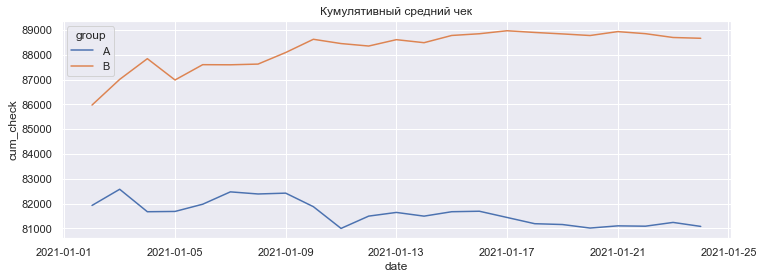

In [19]:
# кумулятивный средний чек
fig, axes = plt.subplots(figsize=(12, 4))

#графики для каждой группы
sns.lineplot(data=data_daily, x='date', y='cum_check', hue='group', ax=axes)

#задаём название графику
axes.set_title('Кумулятивный средний чек')

*Значения кумулятивной конверсии стабилизированись примерно после 2021-01-17 в обеих группах. При этом конверсия в группе А стабильно выше конверсии в группе В (за исключением двух дней 10-11 января 2021.*

*В начале тестирования разница между конверсиями двух групп была 0.4 - 0.6 п.п., затем сократилась до 0 на пару дней, и затем стабилизировалась на уровне чуть меньше 0.2 п.п.*

*Значения среднего чека в обеих группах стабилизировались примерно после 11 января: для группы А на уровне 88 - 89 тыс руб, для группы В - 81 - 82 тыс руб. При этом средний чек в группе В стабильно выше, и разница выросла к середине периода тестирования.*

**Можно считать A/B тестирование завершённым.**

## Проверка статистической значимости разницы между метриками в группах

In [20]:
# обратимся к данным по каждой группе, подготовленным выше
data_grouped

,group,count_visits,count_purchases,sum_price,conversion,mean_check
0,A,145307,17487,1417780000,12.03,8.107623e+06
1,B,145381,17290,1533010000,11.89,8.866455e+06


In [21]:
# для подтверждения статистической разницы между конверсиями в двух группах применим z-тест для пропорций

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(count=data_grouped['count_purchases'], # число "успехов"
                               nobs=data_grouped['count_visits'], # общее число наблюдений
                               alternative='larger')

# выводим результат на экран
print('p-value: ', round(p_value, 2))

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0)) 

p-value:  0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Наш тест не обнаружил статистической разницы между конверсиями в группах А и В.

Убедимся в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используем $z_{крит}$ в своих расчетах

In [22]:
# доверительный интервал для конверсии

def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)


#фильтруем данные группы А
a_data = data[data['group'] == 'A']
#фильтруем данные группы B
b_data = data[data['group'] == 'B']

conf_interval_a = proportions_conf_interval(n=a_data['user_id'].count(), # размер выборки
                                            x_p=a_data['purchase'].mean() # выборочная пропорция
                                            )
conf_interval_b = proportions_conf_interval(n=b_data['user_id'].count(), # размер выборки
                                            x_p=b_data['purchase'].mean() # выборочная пропорция
                                            )

print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.21)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [23]:
# доверительный интервал для разницы конверсий

def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)


# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)

print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


95%-ые доверительные интервалы для группы А и группы В пересекаются. Истинные значения конверсии, которые нас интересуют, могут попасть в зону пересечения. 

**То есть мы не можем однозначно сказать, есть ли разница в конверсиях. Такой результат согласуется с результатом проведённого выше z-теста.**

Истинное значение разницы между конверсиями группы А и группы А может быть как положительным, так и отрицательным (левая и правая границы доверительного интервала имеют разные знаки). 

Для проверки стат. разницы между размерами средних чеков сначала выясним, имеют ли наши данные нормальное распределение. Это повлияет на выбор теста.

Для проверки гипотезы о нормальности распределения средних чеков применим тест Шапиро-Уилка, т.к. имеем дело с количественными данными

In [24]:
# Определим гипотезы и уровень значимости
H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (отвергаем H0)'

alpha = 0.05

# Подготовка данных о среднем чеке
shapiro_a = data_daily[data_daily['group'] == 'A']['mean_check']
shapiro_b = data_daily[data_daily['group'] == 'B']['mean_check']

# Тест
w_a, p_a = shapiro(shapiro_a)
print('p(group A)=%.3f' % p_a)

w_b, p_b = shapiro(shapiro_b)
print('p(group B)=%.3f' % p_b)


p(group A)=0.253
p(group B)=0.094


В обоих случаях полученное значение p (вероятность принять ошибочное решение, отвергнув нулевую гипотезу), больше уровня стат. значимости 0.05.

**Принимаем нулевую гипотезу о нормальности распределения среднего чека в обоих группах.**

Сравним варианты дизайна страницы по метрике среднего чека. 

Имеем данные за 23 дня для каждой группы - размер выборки меньше 30, данные числовые, непрерывные, нормально распределены.
Данные сравниваются по одному и тому же параметру.
Для проверки гипотезы о равенстве средних чеков в двух группах будем использовать T-тест.

In [25]:
# Определим гипотезы и уровень значимости
H0 = 'Ежедневные средние чеки в группах А и B равны'
Ha = 'Ежедневный средний чек в группе А меньше чем в группе B'

aplpha = 0.05

# Тест
st_t, p = ttest_ind(shapiro_a, shapiro_b, equal_var=True)

# Интерпретация
p = round(p,5)

if p>alpha:
    print(f"{p} > {alpha}. Не можем отвергнуть нулевую гипотезу. {H0}")
else:
    print(f"{p} <= {alpha}. Отвергаем нулевую гипотезу. {Ha}")


0.0 <= 0.05. Отвергаем нулевую гипотезу. Ежедневный средний чек в группе А меньше чем в группе B


Если мы отвергнем нулевую гипотезу, вероятность ошибки будет равна 0 с точностью до 5 знаков после запятой.

Поэтому отвергаем эту гипотезу и принимаем альтернативную - **есть статистическая разница в средних чеках двух групп, средний чек в группе А меньше, чем в группе В.**

In [27]:
# 95%-ые доверительные интервалы для средних чеков обеих групп

def mean_conf_interval(n, x_mean, x_std, gamma=0.95):
    k = n - 1 # число степеней свободы
    alpha = 1 - gamma # уровень значимости

    t_crit = -t.ppf(alpha/2, k) # табличное значение t-критическое
    eps = t_crit * x_std/(n**0.5) # погрешность
    lower_bound = x_mean - eps # нижняя граница интервала
    upper_bound = x_mean + eps  # верхняя граница интервала
    confidence_interval = (round(lower_bound), round(upper_bound))
    return confidence_interval


n = data_daily.shape[0]/2 # размер выборки

# Группа А
x_mean = shapiro_a.mean() # выборочное среднее
x_std = shapiro_a.std() # выборочное стандартное отклонение
conf_int = mean_conf_interval(n, x_mean, x_std)
print('Доверительный интервал для среднего чека гр. А: {}'.format(conf_int)) # выводим результат

# Группа B
x_mean = shapiro_b.mean() # выборочное среднее
x_std = shapiro_b.std() # выборочное стандартное отклонение
conf_int = mean_conf_interval(n, x_mean, x_std)
print('Доверительный интервал для среднего чека гр. B: {}'.format(conf_int)) # выводим результат

Доверительный интервал для среднего чека гр. А: (79630, 82308)
Доверительный интервал для среднего чека гр. B: (87626, 89526)


Доверительные интервалы не пересекаются. **С вероятностью 95%** истинные значения средних чеков обеих групп лежат в соответствующих доверительных интервалах, **и между этими значениями существует статистически значимая разница.**

## Общий вывод по результатам AB теста

Был проведён AB тест на выборке достаточного размера для двух групп. 

Сравнивалась эффективность двух вариантов посадочной страницы по двум параметрам: конверсия и средний чек.

Результаты теста показали, что нет статистической разницы между конверсией в двух группах, но есть разница в размерах среднего чека - средний чек в группе В выше.

**Таким образом, вариант дизайна страницы В в целом выглядит эффективнее.**